# Tech Covered Call Portfolio Simulation
Strategy and simulation for covered call strategy

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Distances ─ v0.10.11
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Manifest.toml`
Precompiling project...
  ✓ Distances
  ✓ ChainRulesCore
  ✓ Distances → DistancesSparseArraysExt
  ✓ ChainRulesCore → ChainRulesCoreSparseArraysExt
  ✓ AbstractFFTs → AbstractFFTsChainRulesCoreExt
  ✓ Distances → DistancesChainRulesCoreExt
  ✓ LogExpFunctions → LogExpFunctionsChainRulesCoreExt
  ✓ Interpolations
  ✓ NearestNeighbors
  ✓ StatsBase
  ✓ SpecialFunctions
  ✓ MultivariateStats
  ✓ DiffRules
  ✓ ColorVectorSpace → SpecialFunctionsExt
  ✓ DualNumbers
  ✓ Clustering
  ✓ SpecialFunctions → SpecialFunctionsChainRulesCoreExt
  ✓ HypergeometricFunctions
  ✓ ForwardDiff
  ✓ ForwardDiff →

## Prerequisites: Load historical dataset, compute expected returns and get 2023 `SPY` data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [2]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-12-01-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [5]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [6]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

### Compute the expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);

## Compute the covariance and expected yield for all firms in the dataset

In [10]:
sims = load(joinpath(_PATH_TO_DATA, "SIMs-TechPortfolio-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["sims"];

In [13]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

In [14]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
r_SPY = μ[index_SPY]

0.08947352945602301

In [15]:
σₘ = std(all_firms_return_matrix[:, index_SPY])

2.5345018373000348

In [16]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

In [17]:
total_initial_budget = 1000.0; 

In [18]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-TechPortfolio-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.0191864,0.167056,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[-6.98601e-9, -8.34721e-10, 1.70844e-8, -7.47118e-9, 1.17164e-9, 1.0]",0.05
2,0.0191864,0.167056,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[-6.97459e-9, -7.79913e-10, 1.74159e-8, -7.45651e-9, 1.47198e-9, 1.0]",0.05
3,0.0191864,0.167056,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[-6.96907e-9, -8.90055e-10, 1.70512e-8, -7.4328e-9, 2.05157e-9, 1.0]",0.05
4,0.0191865,0.167056,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[6.44044e-8, 2.0352e-7, 4.63852e-7, 5.31361e-8, 2.60022e-7, 0.999999]",0.05
5,0.0191865,0.167056,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[6.56261e-8, 2.32886e-7, 5.4276e-7, 5.13654e-8, 1.81392e-7, 0.999999]",0.05
6,0.0227273,0.167689,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[1.24886e-7, 5.96257e-7, 0.0262797, 6.36414e-8, 2.76988e-7, 0.973719]",0.05
7,0.0272728,0.168629,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[2.01026e-7, 3.25692e-6, 0.0600127, 6.7028e-8, 3.01259e-7, 0.939983]",0.05
8,0.0318182,0.169712,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[-2.32972e-9, 1.2831e-7, 0.0937528, -6.82219e-9, 3.09557e-9, 0.906247]",0.05
9,0.0363637,0.170931,"[""AMD"", ""AAPL"", ""MSFT"", ""NVDA"", ""ADBE"", ""SPY""]","[2.24809e-7, 0.00406592, 0.122978, 7.23756e-8, 3.38715e-7, 0.872955]",0.05


In [78]:
portfolio_index = 13;

In [96]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
risk = efficient_frontier[portfolio_index,:risk] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)

0.055

In [97]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,AMD,1.0e-6
2,AAPL,0.057493
3,MSFT,0.198656
4,NVDA,0.0
5,ADBE,0.0
6,SPY,0.743849


In [98]:
Sₒ = Array{Float64,1}() # these are close prices at the end of Jan 3, 2023
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close] 
    push!(Sₒ,startprice)
end

In [99]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_initial_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ

6-element Vector{Float64}:
 1.562011871290222e-5
 0.45968657551771014
 0.8291844060439102
 0.0
 0.0
 1.953282390630744

In [100]:
number_of_trading_days = 120;

In [101]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [102]:
α = 0.01;

In [103]:
# setup the bounds
number_of_firms = length(my_list_of_tickers);
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;

# build an inital problem instance (we'll update in the main simulation loop)
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = w, # let start with the initial optimal allocation 
    R = 0.0
));
     

In [104]:
next_market_day_close_queue = Queue{Vector{Float64}}()
for i ∈ 2:(number_of_trading_days + 1)
    
    price_array = Array{Float64,1}();
    for ticker ∈ my_list_of_tickers
        price_df = dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[i,:close] # get the close price starting *after* Jan 03, 2023
        push!(price_array,startprice)
    end
    
    # add the price array to the queue -
    enqueue!(next_market_day_close_queue, price_array);
end

In [105]:
minimum_desired_return = 10*r_SPY # multiple of expected SPY return

0.89473529456023

In [106]:
previous_price_array = Sₒ
μ̂_previous = μ̂
N_previous = Nₒ
Δt = (1/252);
my_results_df = DataFrame();
while (isempty(next_market_day_close_queue) == false)
    
    # what was the market vwap
    current_price_array = dequeue!(next_market_day_close_queue); # holds the close price at the end of the trading day
    
    # compute the return -
    asset_return_array = Array{Float64,1}();
    for j ∈ eachindex(my_list_of_tickers)
        tmp = (1/Δt)*log(current_price_array[j]/previous_price_array[j]);
        push!(asset_return_array,tmp);
    end
    
    # update the average return for each asset -
    μ̂_new = μ̂_previous .+ α*(asset_return_array .- μ̂_previous);
    
    # compute new allocation -
    problem_risk_sim.μ = μ̂_new;
    problem_risk_sim.R = minimum_desired_return;
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    w_new = w; # initialize to orginal portfolio -
    risk_new = risk; # initialize to orginal portfolio -
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        w_new = solution_sim["argmax"];
        risk_new = sqrt(solution_sim["objective_value"]);
    end
    
    # liqudation value of the portfolio at the close of trading day i
    liquidation_value_of_porfolio = dot(N_previous, current_price_array);
    
    # compute the number of shares for the new allocation -
    N_new = Array{Float64,1}()
    for i ∈ eachindex(w_new)
        wᵢ = w_new[i]
        nᵢ = (wᵢ*liquidation_value_of_porfolio)/current_price_array[i];
        push!(N_new,nᵢ)
    end
    
    # store data -
    results_tuple = (
        N_new = N_new,
        N_old = N_previous,
        w_old = w,
        w_new = w_new,
        μ_previous = μ̂_previous,
        μ_new = μ̂_new,
        previous_close = previous_price_array,
        current_close = current_price_array,
        liquidation_value_of_porfolio = liquidation_value_of_porfolio,
        risk = risk_new
    );
    push!(my_results_df,results_tuple)
    
    # update values -
    μ̂_previous = μ̂_new;
    previous_price_array = current_price_array;
    N_previous = N_new;
end
my_results_df

Row,N_new,N_old,w_old,w_new,μ_previous,μ_new,previous_close,current_close,liquidation_value_of_porfolio,risk
,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Float64,Float64
1,"[1.54291e-5, 0.453922, 0.865073, 0.0, 0.0, 1.93375]","[1.56201e-5, 0.459687, 0.829184, 0.0, 0.0, 1.95328]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.394844, 0.251306, 0.24832, 0.370636, 0.206192, 0.0894735]","[0.415963, 0.274651, 0.13312, 0.442196, 0.237491, 0.107959]","[64.02, 125.07, 239.58, 143.15, 336.92, 380.82]","[64.66, 126.36, 229.1, 147.49, 341.41, 383.76]",997.645,0.176599
2,"[1.5766e-5, 0.451911, 0.878132, 0.0, 0.0, 1.92676]","[1.54291e-5, 0.453922, 0.865073, 0.0, 0.0, 1.93375]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.415963, 0.274651, 0.13312, 0.442196, 0.237491, 0.107959]","[0.319319, 0.245038, 0.0559731, 0.353691, 0.137517, 0.0779522]","[64.66, 126.36, 229.1, 147.49, 341.41, 383.76]","[62.33, 125.02, 222.31, 142.65, 328.44, 379.38]",982.692,0.176599
3,"[1.56947e-5, 0.445251, 0.886576, 0.0, 0.0, 1.92409]","[1.5766e-5, 0.451911, 0.878132, 0.0, 0.0, 1.92676]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.319319, 0.245038, 0.0559731, 0.353691, 0.137517, 0.0779522]","[0.38118, 0.333644, 0.0849388, 0.452962, 0.168995, 0.134309]","[62.33, 125.02, 222.31, 142.65, 328.44, 379.38]","[63.96, 129.62, 224.93, 148.59, 332.75, 388.08]",1003.83,0.176599
4,"[1.49552e-5, 0.444212, 0.879561, 0.0, 0.0, 1.92854]","[1.56947e-5, 0.445251, 0.886576, 0.0, 0.0, 1.92409]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.38118, 0.333644, 0.0849388, 0.452962, 0.168995, 0.134309]","[0.503395, 0.340591, 0.108506, 0.575587, 0.236255, 0.131537]","[63.96, 129.62, 224.93, 148.59, 332.75, 388.08]","[67.24, 130.15, 227.12, 156.28, 341.98, 387.86]",1005.59,0.176599
5,"[1.48804e-5, 0.44533, 0.879009, 0.0, 0.0, 1.92849]","[1.49552e-5, 0.444212, 0.879561, 0.0, 0.0, 1.92854]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.503395, 0.340591, 0.108506, 0.575587, 0.236255, 0.131537]","[0.528536, 0.34839, 0.126544, 0.61474, 0.209606, 0.147832]","[67.24, 130.15, 227.12, 156.28, 341.98, 387.86]","[68.05, 130.73, 228.85, 159.09, 338.7, 390.58]",1012.61,0.176599
6,"[1.49066e-5, 0.443374, 0.867396, 0.0, 0.0, 1.93607]","[1.48804e-5, 0.44533, 0.879009, 0.0, 0.0, 1.92849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.528536, 0.34839, 0.126544, 0.61474, 0.209606, 0.147832]","[0.560378, 0.397555, 0.200349, 0.623123, 0.238787, 0.178027]","[68.05, 130.73, 228.85, 159.09, 338.7, 390.58]","[69.06, 133.49, 235.77, 160.01, 342.93, 395.52]",1029.45,0.176599
7,"[1.46127e-5, 0.44585, 0.861703, 0.0, 0.0, 1.93865]","[1.49066e-5, 0.443374, 0.867396, 0.0, 0.0, 1.93607]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.560378, 0.397555, 0.200349, 0.623123, 0.238787, 0.178027]","[0.61748, 0.392069, 0.227463, 0.695959, 0.248202, 0.185405]","[69.06, 133.49, 235.77, 160.01, 342.93, 395.52]","[70.8, 133.41, 238.51, 165.11, 344.54, 396.96]",1034.58,0.176599
8,"[1.46307e-5, 0.443179, 0.862603, 0.0, 0.0, 1.93902]","[1.46127e-5, 0.44585, 0.861703, 0.0, 0.0, 1.93865]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[0.61748, 0.392069, 0.227463, 0.695959, 0.248202, 0.185405]","[0.618414, 0.41352, 0.232784, 0.747533, 0.24455, 0.193308]","[70.8, 133.41, 238.51, 165.11, 344.54, 396.96]","[71.0, 134.76, 239.23, 168.99, 344.38, 398.5]",1038.78,0.176599
9,"[1.45112e-5, 0.439362, 0.858643, 0.0, 0.0, 1.94271]","[1.46307e-5, 0.443179, 0.862603, 0.0, 0.0, 1.93902]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.0, 0.743849]","[1.0e-6, 0.057493, 0.198656, 0.0, 0.

In [107]:
portfolio_performance_array_original = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_trading_days
        portfolio_performance_array_original[j,i] = nᵢ*ticker_data[j+1,:close];
    end
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_original[i,end] = sum(portfolio_performance_array_original[i,1:end-2])
end

# compute the risk -
for i ∈ 1:number_of_trading_days
    data = portfolio_performance_array_original[i,1:end-2];
    total = portfolio_performance_array_original[i,end];
    w = (1/total)*data;
    portfolio_performance_array_original[i,end-1] = transpose(w)*Σ̂*w |> sqrt
end

In [108]:
orignal_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    orignal_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        orignal_table_data[i,1+j] = portfolio_performance_array_original[i,j];
    end
    orignal_table_data[i,end-1] = portfolio_performance_array_original[i,end-1]
    orignal_table_data[i,end] = portfolio_performance_array_original[i,end]
end

pretty_table(orignal_table_data, header=["index",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬─────────────┬─────────┬─────────┬──────┬──────┬─────────┬─────────────┬───────────┐
│ index │         AMD │    AAPL │    MSFT │ NVDA │ ADBE │     SPY │ risk (sqrt) │ total USD │
├───────┼─────────────┼─────────┼─────────┼──────┼──────┼─────────┼─────────────┼───────────┤
│   1.0 │     0.00101 │  58.086 │ 189.966 │  0.0 │  0.0 │ 749.592 │    0.168683 │   997.645 │
│   2.0 │ 0.000973602 │   57.47 │ 184.336 │  0.0 │  0.0 │ 741.036 │    0.168566 │   982.843 │
│   3.0 │ 0.000999063 │ 59.5846 │ 186.508 │  0.0 │  0.0 │  758.03 │    0.168528 │   1004.12 │
│   4.0 │   0.0010503 │ 59.8282 │ 188.324 │  0.0 │  0.0 │   757.6 │    0.168603 │   1005.75 │
│   5.0 │  0.00106295 │ 60.0948 │ 189.759 │  0.0 │  0.0 │ 762.913 │    0.168601 │   1012.77 │
│   6.0 │  0.00107873 │ 61.3636 │ 195.497 │  0.0 │  0.0 │ 772.562 │    0.168729 │   1029.42 │
│   7.0 │   0.0011059 │ 61.3268 │ 197.769 │  0.0 │  0.0 │ 775.375 │     0.16877 │   1034.47 │
│   8.0 │  0.00110903 │ 61.9474 │ 198.366 │  0.0 │  0.0 │ 77

In [109]:
portfolio_performance_array_reallocate = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)

# values for each asset -
for i ∈ 1:(number_of_trading_days)
    
    risk_new = my_results_df[i,:risk]
    N_new = my_results_df[i,:N_new]
    new_price = my_results_df[i,:current_close]
    
    for j ∈ eachindex(my_list_of_tickers)
        portfolio_performance_array_reallocate[i,j] = N_new[j]*new_price[j] |> x-> round(x, digits=3) |> abs
    end
    
    # compute the risk -
    portfolio_performance_array_reallocate[i,end-1] = risk_new
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_reallocate[i,end] = sum(portfolio_performance_array_reallocate[i,1:end-2])
end

# compute the initial risk -
total = portfolio_performance_array_reallocate[1,end];
data = portfolio_performance_array_reallocate[1,1:end-2];
w = (1/total)*data
portfolio_performance_array_reallocate[1,end-1] = transpose(w)*Σ̂*w |> sqrt;

In [110]:
reallocate_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    reallocate_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        reallocate_table_data[i,1+j] = portfolio_performance_array_reallocate[i,j];
    end
    reallocate_table_data[i,end-1] = portfolio_performance_array_reallocate[i,end-1]
    reallocate_table_data[i,end] = portfolio_performance_array_reallocate[i,end]
end

pretty_table(reallocate_table_data, header=["day",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────────┬───────────┐
│   day │     AMD │    AAPL │    MSFT │    NVDA │    ADBE │     SPY │ risk (sqrt) │ total USD │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────────┼───────────┤
│   1.0 │   0.001 │  57.358 │ 198.188 │     0.0 │     0.0 │ 742.097 │    0.169023 │   997.644 │
│   2.0 │   0.001 │  56.498 │ 195.218 │     0.0 │     0.0 │ 730.974 │    0.176599 │   982.691 │
│   3.0 │   0.001 │  57.713 │ 199.417 │     0.0 │     0.0 │   746.7 │    0.176599 │   1003.83 │
│   4.0 │   0.001 │  57.814 │ 199.766 │     0.0 │     0.0 │ 748.005 │    0.176599 │   1005.59 │
│   5.0 │   0.001 │  58.218 │ 201.161 │     0.0 │     0.0 │ 753.229 │    0.176599 │   1012.61 │
│   6.0 │   0.001 │  59.186 │ 204.506 │     0.0 │     0.0 │ 765.754 │    0.176599 │   1029.45 │
│   7.0 │   0.001 │  59.481 │ 205.525 │     0.0 │     0.0 │ 769.568 │    0.176599 │   1034.58 │
│   8.0 │   0.001 │  59.723 │  206.36 │ 

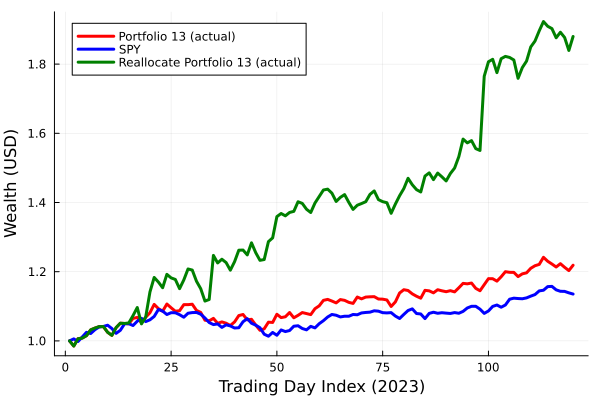

In [111]:
plot((1/portfolio_performance_array_original[1,end]).*portfolio_performance_array_original[:,end], 
    lw=3, c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:number_of_trading_days,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
plot!((1/portfolio_performance_array_reallocate[1,end]).*portfolio_performance_array_reallocate[:,end], lw=3, 
    c=:green, label="Reallocate Portfolio $(portfolio_index) (actual)")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.